In [1]:
import brightway2 as bw

In [2]:
from time import time

In [3]:
bw.projects.set_current("bw2 seminar 2017 😄")

***Read only project***

This project is being used by another process and no writes can be made until:
    1. You close the other program, or switch to a different project, *and*
    2. You call `projects.enable_writes` *and* get the response `True`.

    If you are **sure** that this warning is incorrect, call
    `projects.enable_writes(force=True)` to enable writes.



In [4]:
db = bw.Database("ecoinvent")

In [17]:
a = db.random()
print(a)

for x in a.technosphere():
    print(x['amount'], x['uncertainty type'], x['scale'], bw.mapping[x['input']], x.input)

'disposal, long-distance train' (unit, CH, ['transport systems', 'train'])
4420.0 2 0.41208772148317463 5843 'transport, lorry 20-28t, fleet average' (ton kilometer, CH, ['transport systems', 'road'])
645.0 2 0.11555586048169333 5994 'disposal, emulsion paint, 0% water, to municipal incineration' (kilogram, CH, ['waste management', 'municipal incineration'])
9510.0 2 0.11555586048169333 5996 'disposal, glass, 0% water, to municipal incineration' (kilogram, CH, ['waste management', 'municipal incineration'])
78200.0 2 0.11555586048169333 6113 'disposal, plastics, mixture, 15.3% water, to sanitary landfill' (kilogram, CH, ['waste management', 'sanitary landfill'])


In [18]:
m = ('CML 2001', 'climate change', 'GWP 500a')

In [19]:
pv = bw.ParameterVectorLCA({a.key: 1}, m)
next(pv)

8224.67588583683

In [20]:
index = bw.mapping[a]

ra, _, _ = pv.reverse_dict()

indices = []

for i, x in enumerate(pv.tech_params):
    if x['output'] == index:
        if x['output'] != x['input']:
            indices.append(i)
        print(i, bw.get_activity(ra[int(x['row'])]))

2596 'disposal, long-distance train' (unit, CH, ['transport systems', 'train'])
28112 'transport, lorry 20-28t, fleet average' (ton kilometer, CH, ['transport systems', 'road'])
33529 'disposal, emulsion paint, 0% water, to municipal incineration' (kilogram, CH, ['waste management', 'municipal incineration'])
33565 'disposal, glass, 0% water, to municipal incineration' (kilogram, CH, ['waste management', 'municipal incineration'])
36368 'disposal, plastics, mixture, 15.3% water, to sanitary landfill' (kilogram, CH, ['waste management', 'sanitary landfill'])


In [21]:
from bw2calc import ParameterVectorLCA, ParallelMonteCarlo
from scipy.stats import ks_2samp
from stats_arrays import uncertainty_choices
import multiprocessing
import numpy as np


def pawn_worker(args):
    fu, method, index, unconditional_cdf, n_c, n = args
    lca = ParameterVectorLCA(fu, method)
    lca.load_data()
    next(lca)
    array = lca.params[index:index + 1]
    lhc = (np.random.random(size=n) + np.arange(n)) / n
    n_samples = uncertainty_choices[int(array['uncertainty_type'][0])].ppf(
        array, lhc.reshape((1, -1))).ravel()
    results = []

    for fixed in n_samples:

        scores = []

        for _ in range(n_c):
            sample = lca.rng.next()
            sample[index] = fixed

            lca.rebuild_all(sample)
            lca.lci_calculation()
            lca.lcia_calculation()
            scores.append(lca.score)

        results.append(ks_2samp(unconditional_cdf, np.array(scores))[0])

    return (index, np.median(results))
    

def pawn_sensitivity(fu, method, indices, cpus=None, n_u=1000, n_c=100, n=20):
    unconditional_cdf = ParallelMonteCarlo(fu, method, n_u, cpus=cpus).calculate()

    with multiprocessing.Pool(processes=cpus) as pool:
        results = pool.map(
            pawn_worker,
            [(fu, method, index, unconditional_cdf.copy(), n_c, n) 
             for index in indices]
        )
    return results

In [22]:
def pawn_worker_full(args):
    fu, method, index, unconditional_cdf, n_c, n = args
    lca = ParameterVectorLCA(fu, method)
    lca.load_data()
    next(lca)
    array = lca.params[index:index + 1]
    lhc = (np.random.random(size=n) + np.arange(n)) / n
    n_samples = uncertainty_choices[int(array['uncertainty_type'][0])].ppf(
        array, lhc.reshape((1, -1))).ravel()
    results = []

    for fixed in n_samples:

        scores = []

        for _ in range(n_c):
            sample = lca.rng.next()
            sample[index] = fixed

            lca.rebuild_all(sample)
            lca.lci_calculation()
            lca.lcia_calculation()
            scores.append(lca.score)

        results.append(np.array(scores))

    return (index, results)
    

def pawn_sensitivity_full(fu, method, indices, cpus=None, n_u=1000, n_c=100, n=20):
    unconditional_cdf = ParallelMonteCarlo(fu, method, n_u, cpus=cpus).calculate()

    with multiprocessing.Pool(processes=cpus) as pool:
        results = pool.map(
            pawn_worker_full,
            [(fu, method, index, unconditional_cdf.copy(), n_c, n) 
             for index in indices]
        )
    return unconditional_cdf, results

In [26]:
%matplotlib inline

In [27]:
from matplotlib import pyplot as plt

In [28]:
empirical_cdf = lambda xs: np.linspace(0, 1, int(xs.shape[0]))

In [29]:
start = time()
unconditional_cdf, results = pawn_sensitivity_full({a.key: 1}, m, indices)
(time() - start) / 60

1.9920399904251098

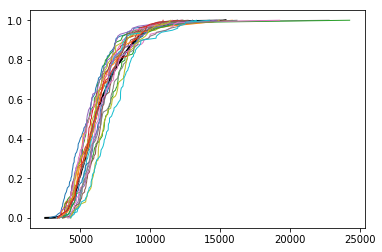

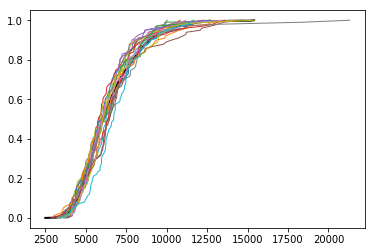

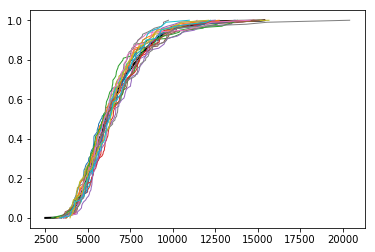

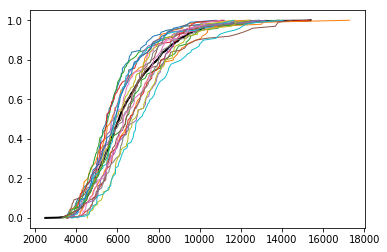

In [30]:
for index, conditional_cdfs in results:

    xs = np.sort(unconditional_cdf)
    plt.plot(xs, empirical_cdf(xs), lw=2, color='black')

    for ds in conditional_cdfs:
        ds = np.sort(ds)
        plt.plot(ds, empirical_cdf(ds), lw=1, ls='-')
    plt.show()

In [32]:
for index, conditional_cdfs in results:
    print(index, np.median([ks_2samp(unconditional_cdf, sample)[0] for sample in conditional_cdfs]))

28112 0.138154761905
33529 0.0980357142857
33565 0.0914285714286
36368 0.141527777778
